In [1]:
%pylab inline
%matplotlib inline
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/Users/Argen/Documents/MAS/R&D/Code/pgm'])

Populating the interactive namespace from numpy and matplotlib
Python 2.7.10 |Anaconda 2.3.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)] on darwin


In [2]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

In [3]:
import numpy as np
from itertools import combinations, izip, product
import matplotlib.pyplot as plt

In [4]:
import networkx as nx
import pandas as pd

In [5]:
from pgm.utils.tools import draw_graph, node_types
from pgm.nodes.chance import Chance, CPT
from pgm.nodes.decision import Decision
from pgm.nodes.utility import Utility, UT

In [6]:
nodes = [('A', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('C', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('B', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('E', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('D', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('G', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('F', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('I', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('H', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('K', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('J', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('L', {'domain': ['T', 'F'], 'type': 'chance'}), 
         ('V1', {'type': 'utility'}), 
         ('V2', {'type': 'utility'}), 
         ('V3', {'type': 'utility'}), 
         ('V4', {'type': 'utility'}), 
         ('D4', {'domain': ['d1', 'd2'], 'type': 'decision'}), 
         ('D2', {'domain': ['d1', 'd2'], 'type': 'decision'}), 
         ('D3', {'domain': ['d1', 'd2'], 'type': 'decision'}), 
         ('D1', {'domain': ['d1', 'd2'], 'type': 'decision'})]

edges = [('A', 'C', {'type': 'causal'}), 
         ('C', 'E', {'type': 'causal'}), 
         ('B', 'C', {'type': 'causal'}), 
         ('B', 'D', {'type': 'causal'}), 
         ('B', 'D1', {'type': 'causal'}), 
         ('E', 'D2', {'type': 'causal'}), 
         ('E', 'G', {'type': 'causal'}), 
         ('D', 'E', {'type': 'causal'}), 
         ('D', 'F', {'type': 'causal'}), 
         ('G', 'I', {'type': 'causal'}), 
         ('G', 'D4', {'type': 'causal'}), 
         ('F', 'H', {'type': 'causal'}), 
         ('F', 'D2', {'type': 'causal'}), 
         ('I', 'L', {'type': 'causal'}), 
         ('H', 'K', {'type': 'causal'}), 
         ('H', 'J', {'type': 'causal'}), 
         ('K', 'V3', {'type': 'causal'}), 
         ('J', 'V3', {'type': 'causal'}), 
         ('L', 'V4', {'type': 'causal'}), 
         ('D4', 'L', {'type': 'causal'}), 
         ('D2', 'I', {'type': 'causal'}), 
         ('D2', 'D3', {'type': 'causal'}), 
         ('D3', 'D4', {'type': 'causal'}), 
         ('D3', 'K', {'type': 'causal'}), 
         ('D3', 'V2', {'type': 'causal'}), 
         ('D1', 'V1', {'type': 'causal'}), 
         ('D1', 'D', {'type': 'causal'})]

other


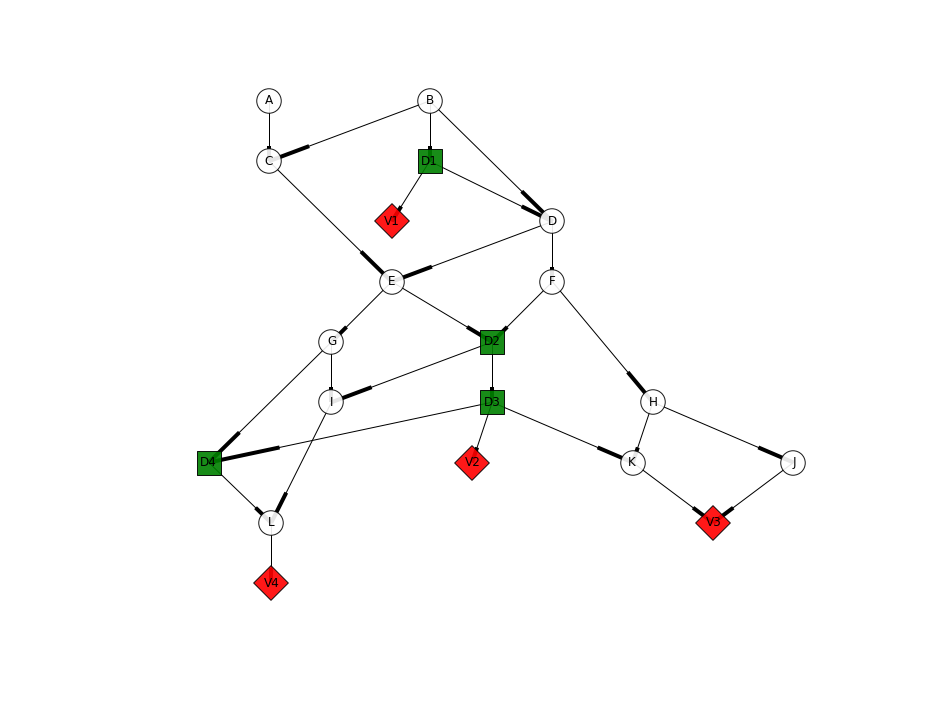

In [7]:
net = nx.DiGraph()
net.add_nodes_from(nodes)
net.add_edges_from(edges)

pos = nx.graphviz_layout(net, prog='dot')
draw_graph(net)

### Conditional Probability Tables

In [8]:
def cpt(graph, node, data):
    domain = graph.node[node]['domain']
    n = 1
    m = len(domain)
    
    parents = graph.predecessors(node)
    
    parents_names = []
    parents_domains = []  
    
    rows = pd.MultiIndex.from_product([domain], names=[node])
    
    for parent in parents:
            dom = graph.node[parent]['domain']
            n = n * len(dom)
            parents_names.append(parent)
            parents_domains.append(dom)
    
    if parents and data.shape == (m,n):
        values = data
    elif not parents and (data.shape ==(m,) or data.shape == (m,1)):
        values = data.flatten()
    else:
        print 'Data error, shape should be (%i,%i)'%(m, n)
        values = np.zeros((m,n))
    
    if parents:
        cols = pd.MultiIndex.from_product(parents_domains, names=parents_names)
        table = pd.DataFrame(values, index=rows, columns=cols)
    else:
        table = pd.Series(values, index=rows,name=node)
    return table
    
    
    
data = np.array([[0.8,0.2]]).T
a = cpt(net, 'A', data)
a

A
T    0.8
F    0.2
Name: A, dtype: float64

In [9]:
data = np.array([[0.8,0.2], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T
print data.shape
e = cpt(net, 'E', data)
e

(2, 4)


C    T         F      
D    T    F    T     F
E                     
T  0.8  0.6  0.3  0.25
F  0.2  0.4  0.7  0.75

In [10]:
def ut(graph, node, data):
    m = 1
    n = 1
    
    parents = graph.predecessors(node)
    
    parents_names = []
    parents_domains = []
    
    for parent in parents:
        dom = graph.node[parent]['domain']
        m = m * len(dom)
        parents_names.append(parent)
        parents_domains.append(dom)
    
    cols = pd.MultiIndex.from_product([node], names=[node])
    rows = pd.MultiIndex.from_product(parents_domains, names=parents_names)

    if data.shape == (m,) or data.shape== (m,1):
        values = data
    else:
        print 'Data error, shape should be (%i,).'%(m,)
        print 'Data shape: ', data.shape
        values = np.zeros((m,1))
    table = pd.DataFrame(values, index=rows, columns=cols)
    #table = pd.Series(values,index=rows, name=node)
    return table

data = np.array([10,5,3,2])
a = ut(net, 'V3', data)
a


V3   V3
K J    
T T  10
  F   5
F T   3
  F   2

In [11]:
for node in net.nodes():
    t = net.node[node]['type']
    if t is 'chance':
        domain = net.node[node]['domain']     
        m = len(domain)
    elif t is 'utility':
        m=1      
    if t is not 'decision':
        n = 1
        parents = net.predecessors(node)
        for parent in parents:
            dom = net.node[parent]['domain']
            n = n * len(dom)
        print node, m, n 

A 2 1
C 2 4
B 2 1
E 2 4
D 2 4
G 2 2
F 2 2
I 2 4
H 2 2
K 2 4
J 2 2
L 2 4
V1 1 2
V2 1 2
V3 1 4
V4 1 2


In [12]:
a = cpt(net, 'A', np.array([[0.8,0.2]]).T)
b = cpt(net, 'B', np.array([[0.5,0.5]]).T)
c = cpt(net, 'C', np.array([[0.7,0.3], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
d = cpt(net, 'D', np.array([[0.5,0.5], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
e = cpt(net, 'E', np.array([[0.8,0.2], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
f = cpt(net, 'F', np.array([[0.6,0.4],[0.25,0.75]]).T)
g = cpt(net, 'G', np.array([[0.3,0.7],[0.25,0.75]]).T)
h = cpt(net, 'H', np.array([[0.5,0.5], [0.25,0.75]]).T)
i = cpt(net, 'I', np.array([[0.8,0.2], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
j = cpt(net, 'J', np.array([[0.3,0.7],[0.25,0.75]]).T)
k = cpt(net, 'K', np.array([[0.8,0.2], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
l = cpt(net, 'L', np.array([[0.9,0.1], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)

v1 = ut(net, 'V1', np.array([[10, 5]]).T)
v2 = ut(net, 'V2', np.array([[100, 50]]).T)
v3 = ut(net, 'V3', np.array([[30, 45, 80, 120]]).T)
v4 = ut(net, 'V4', np.array([[90, 70]]).T)

tables = [a,b,c,d,e,f,g,h,i,j,k,l,v1,v2,v3,v4]
node_table = ['A','B','C','D','E','F','G','H','I','J','K','L','V1','V2','V3','V4']

print len(tables), len(node_table)

16 16


In [13]:
def add_tables(graph, nodes, tables):
    assert len(tables) == len(nodes)
    nx.set_node_attributes(graph, 'table', dict(zip(nodes,tables)))
        
add_tables(net, node_table, tables)   

###Validation

1. Check that probabilities sum 1
2. Check table sizes are correct

In [19]:
e = net.node['E']['table']
print net.node['E']['domain']
(e.sum()==1).all()

['T', 'F']


True

In [23]:
def validate(graph):
    for n, d in graph.nodes_iter(data=True):
        if d['type'] is 'chance':
            if not (d['table'].sum()==1).all():
                print 'Probability table in node %s should sum 1.'%n
                return False            
            x = 1
            parents = graph.predecessors(n)
            for parent in parents:
                dom = graph.node[parent]['domain']
                x = x * len(dom)
            if parents and not d['table'].shape ==(len(d['domain']), x):
                print 'Error in node %s'%n
                return False
            elif not parents and not d['table'].shape ==(len(d['domain']),):
                print 'Error in node %s'%n
                return False
            
        if d['type'] is 'utility':
            m = 1
            parents = graph.predecessors(n)
            for parent in parents:
                dom = graph.node[parent]['domain']
                m = m * len(dom)
            if not d['table'].shape ==(m, 1):
                print 'Error in node %s'%n
                return False
    return True

validate(net)


True

###Evidence

In [53]:
def unstack_potentials(potentials):
    pots = []
    var = []
    for p in potentials:
        x = p
        if p.ndim != 1:
            for i in p.columns.names:
                x = x.stack(i)
        pots.append(x)
        var.append(set(x.index.names))
    return pots, var

unstack_potentials([e])

([E  C  D
  T  F  F    0.25
        T    0.30
     T  F    0.60
        T    0.80
  F  F  F    0.75
        T    0.70
     T  F    0.40
        T    0.20
  dtype: float64], [{'C', 'D', 'E'}])

In [55]:
t = net.node['E']['table']

def marginalize(var, table):
    '''Variable must exist in table.
    var is a list o variables to be summed out. '''
    m, n = table.shape
    t = table.copy(True)
    
    tables, variables = unstack_potentials([table])
    t = tables[0]
    print t
    names = list(t.index.names)
    for v in var:
        names.remove(v)
    
    return t.groupby(level=names).sum()
    
    '''
    if var in table.index.names:
        names = list(table.index.names)
        names.remove(var)
        return table.groupby(level=names).sum()
    elif var in table.columns.names:
        names = list(table.columns.names)
        names.remove(var)
        return 1
    '''

e

C    T         F      
D    T    F    T     F
E                     
T  0.8  0.6  0.3  0.25
F  0.2  0.4  0.7  0.75

In [56]:
potential = marginalize(['C'], e)
potential

E  C  D
T  F  F    0.25
      T    0.30
   T  F    0.60
      T    0.80
F  F  F    0.75
      T    0.70
   T  F    0.40
      T    0.20
dtype: float64


E  D
T  F    0.85
   T    1.10
F  F    1.15
   T    0.90
dtype: float64

In [20]:
def introduce_evidence(table,evidence):
    print evidence
    index = [evidence.get(t) for t in table.index.names if evidence.get(t) is not None]
    columns = [evidence.get(t) for t in table.columns.names if evidence.get(t) is not None]    
    print tuple(index)
    print tuple(columns)
    if index and columns:
        print table.loc[tuple(index),tuple(columns)]
    elif index:
        print table.loc[tuple(index),:]
    else:
        print table.loc[:,tuple(columns)]
    
evidence = {'D':'T'}

introduce_evidence(t,evidence)

{'D': 'T'}
('T',)
()
E    T    F
D          
T  0.8  0.2
F  0.6  0.4


/Users/Argen/anaconda/lib/python2.7/site-packages/pandas/core/index.py:5091: PerformanceWarning: indexing past lexsort depth may impact performance.
  PerformanceWarning)


#### Multiplying potentials

In [21]:
rows = pd.MultiIndex.from_product([['c1', 'c2', 'c3']], names=['C'])
cols = pd.MultiIndex.from_product([['b1','b2','b3']],names=['B'])
pc_b = pd.DataFrame(np.array([[0.2,0.9,0.3],[0.05,0.05,0.02],[0.75,0.05,0.5]]), index=rows, columns=cols)
pc_b

B,b1,b2,b3
C,,,
c1,0.20,0.90,0.30
c2,0.05,0.05,0.02
c3,0.75,0.05,0.50


In [22]:
rows = pd.MultiIndex.from_product([['a1','a2']], names=['A'])
cols = pd.MultiIndex.from_product([['b1','b2','b3']],names=['B'])
pa_b = pd.DataFrame(np.array([[0.4,0.3,0.6],[0.6,0.7,0.4]]), index=rows, columns=cols)
pa_b

B,b1,b2,b3
A,,,
a1,0.4,0.3,0.6
a2,0.6,0.7,0.4


In [23]:
rows = pd.MultiIndex.from_product([''], names=[''])
cols = pd.MultiIndex.from_product([['b1','b2','b3']],names=['B'])
pb = pd.Series(np.array([0.4,0.4,0.2]), index=cols,name='B')
pb

B
b1    0.4
b2    0.4
b3    0.2
Name: B, dtype: float64

In [24]:
rows = pd.MultiIndex.from_product([''], names=[''])
cols = pd.MultiIndex.from_product([['a1','a2']],names=['A'])
pa = pd.Series(np.array([0.4,0.6]), index=cols, name='A')
pa

A
a1    0.4
a2    0.6
Name: A, dtype: float64

In [25]:
print pa_b.columns.values, pa_b.index.values
print pc_b.columns.values, pc_b.index.values
print pb.index.values
print
print pa_b.columns.names, pa_b.index.names
print pc_b.columns.names, pc_b.index.names
print pb.index.names


['b1' 'b2' 'b3'] ['a1' 'a2']
['b1' 'b2' 'b3'] ['c1' 'c2' 'c3']
['b1' 'b2' 'b3']

[u'B'] [u'A']
[u'B'] [u'C']
[u'B']


In [26]:
def mult(pot1,pot2):
    '''Tables must be aligned.'''
    if pot1.ndim ==1 or pot2.ndim==1:
        return pot1*pot2
    else:
        t1 = pd.concat([pot1]*pot2.shape[0],axis=0, keys=pot2.index.values, names=pot2.index.names)
        t2 = pd.concat([pot2]*pot1.shape[0],axis=0, keys=pot1.index.values, names=pot1.index.names)
        return t1.sort().combineMult(t2.reorder_levels(t1.index.names).sort())
                
pac_b = mult(pc_b,pa_b)
pac_b

B        b1     b2     b3
A  C                     
a1 c1  0.08  0.270  0.180
   c2  0.02  0.015  0.012
   c3  0.30  0.015  0.300
a2 c1  0.12  0.630  0.120
   c2  0.03  0.035  0.008
   c3  0.45  0.035  0.200

In [27]:


def align(potentials, v, verbose=False):
    '''Potentials must have variables in common, and be unstacked.'''
    result = []
    for p in potentials:
        #print p
        #print
        if len(p.index.names) !=1:
            result.append(p.unstack(level=v))
        else:
            result.append(p)   
    if verbose:
        for p in result:
            print p
            print
    
    return result

potentials, variables = unstack_potentials([pa_b, pc_b, pb, pa])
align([pa_b, pc_b, pb],['B'])


[B    b1   b2   b3
 A                
 a1  0.4  0.3  0.6
 a2  0.6  0.7  0.4, B     b1    b2    b3
 C                   
 c1  0.20  0.90  0.30
 c2  0.05  0.05  0.02
 c3  0.75  0.05  0.50, B
 b1    0.4
 b2    0.4
 b3    0.2
 Name: B, dtype: float64]

In [28]:
def multiply_potentials2(potentials):
    pots, var = unstack_potentials(potentials)
    res = []
    #print var
    v = list(set.intersection(*var))
    
    while pots:
        #print pots
        if v:
            #print 'Easy!'
            aligned = align(pots, v)
            result = aligned.pop()
            for p in aligned:
                result = mult(result,p)
            return [result]
        else:
            #print 'Simplifying'
            pot1 = pots.pop()
            v1 = var.pop()
            common = [pot1]
            
            for x in var:
                if set.intersection(x, v1):
                    common.append(pots.pop(var.index(x)))
                    print var.index(x)
                    var.remove(x)
            if len(common)==1:
                res.extend(common)
                if len(pots)==1:
                    res.extend(pots)
                    return res
            else:
                result = multiply_potentials2(common)
                result_unstacked, result_var = unstack_potentials(result)
                pots.insert(0,*result_unstacked)
                var.insert(0,*result_var)
            v = list(set.intersection(*var))

#multiply_potentials2([pa_b, pa, pc_b.T, pb])
#multiply_potentials2([pa_b, pa])
multiply_potentials2([pa,pb])

Simplifying


[B
 b1    0.4
 b2    0.4
 b3    0.2
 Name: B, dtype: float64, A
 a1    0.4
 a2    0.6
 Name: A, dtype: float64]